# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.11KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

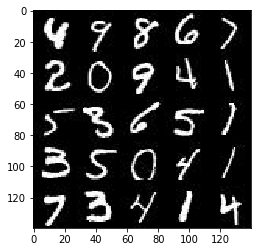

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

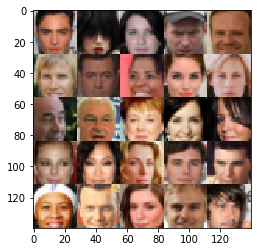

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #14x14x128

        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x256

        flat = tf.reshape(x2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28 x out_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 0.6189... Generator Loss: 1.1841
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.6422
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 0.9342... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 0.6987... Generator Loss: 1.3728
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.2845
Epoch 1/2... Discriminator Loss: 0.6458... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 0.5369... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.3848... Generator Loss: 2.3095


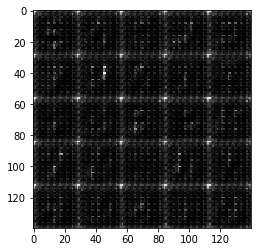

Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 1.6783
Epoch 1/2... Discriminator Loss: 0.4301... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 0.4489... Generator Loss: 1.5015
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 2.2267
Epoch 1/2... Discriminator Loss: 0.4081... Generator Loss: 2.2028
Epoch 1/2... Discriminator Loss: 0.9658... Generator Loss: 2.3020
Epoch 1/2... Discriminator Loss: 0.7590... Generator Loss: 1.1701
Epoch 1/2... Discriminator Loss: 1.2663... Generator Loss: 0.4978
Epoch 1/2... Discriminator Loss: 0.6618... Generator Loss: 3.5269
Epoch 1/2... Discriminator Loss: 1.0109... Generator Loss: 0.6431


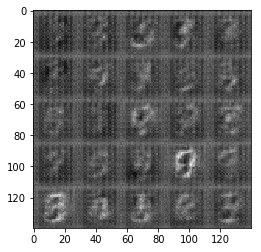

Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.0864
Epoch 1/2... Discriminator Loss: 0.7098... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 0.6924... Generator Loss: 1.9518
Epoch 1/2... Discriminator Loss: 0.8302... Generator Loss: 0.9374
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.8995
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 1.6806
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 2.3044
Epoch 1/2... Discriminator Loss: 0.8486... Generator Loss: 2.0278
Epoch 1/2... Discriminator Loss: 0.6022... Generator Loss: 1.5179
Epoch 1/2... Discriminator Loss: 0.5717... Generator Loss: 1.3926


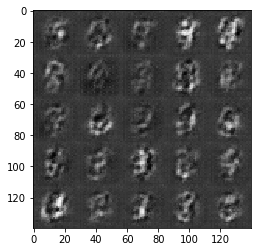

Epoch 1/2... Discriminator Loss: 0.6265... Generator Loss: 2.1524
Epoch 1/2... Discriminator Loss: 0.6221... Generator Loss: 1.0739
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.9767
Epoch 1/2... Discriminator Loss: 0.6988... Generator Loss: 0.9249
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 2.2514
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 1.0520
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 1.8781
Epoch 1/2... Discriminator Loss: 0.5864... Generator Loss: 2.3990
Epoch 1/2... Discriminator Loss: 0.5935... Generator Loss: 2.7762
Epoch 1/2... Discriminator Loss: 0.6483... Generator Loss: 2.7412


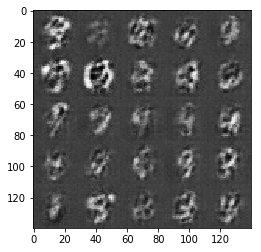

Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 0.5742
Epoch 1/2... Discriminator Loss: 0.4801... Generator Loss: 1.3151
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.1873
Epoch 1/2... Discriminator Loss: 0.5294... Generator Loss: 2.6703
Epoch 1/2... Discriminator Loss: 0.8824... Generator Loss: 3.4258
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 2.3098
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 1.4177
Epoch 2/2... Discriminator Loss: 0.4694... Generator Loss: 2.5661
Epoch 2/2... Discriminator Loss: 0.5475... Generator Loss: 1.1346


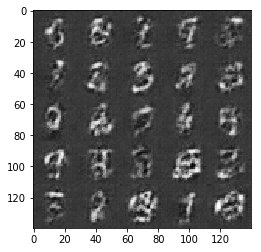

Epoch 2/2... Discriminator Loss: 0.6095... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 0.4056... Generator Loss: 1.6893
Epoch 2/2... Discriminator Loss: 0.4340... Generator Loss: 2.2199
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 0.4481... Generator Loss: 1.3854
Epoch 2/2... Discriminator Loss: 0.5199... Generator Loss: 2.8744
Epoch 2/2... Discriminator Loss: 0.4863... Generator Loss: 1.2470
Epoch 2/2... Discriminator Loss: 0.3529... Generator Loss: 1.7257
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 0.7830


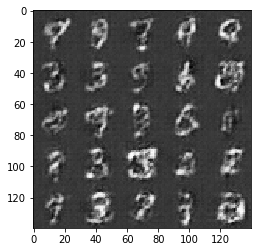

Epoch 2/2... Discriminator Loss: 0.3535... Generator Loss: 1.9651
Epoch 2/2... Discriminator Loss: 0.4946... Generator Loss: 1.3121
Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 0.9079
Epoch 2/2... Discriminator Loss: 0.3420... Generator Loss: 1.9520
Epoch 2/2... Discriminator Loss: 0.3615... Generator Loss: 1.8575
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 3.2875
Epoch 2/2... Discriminator Loss: 0.3521... Generator Loss: 1.6902
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 2.8234
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 1.7292
Epoch 2/2... Discriminator Loss: 0.7388... Generator Loss: 3.3390


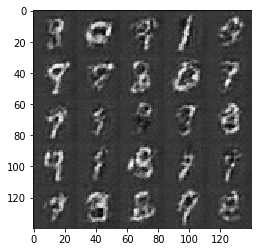

Epoch 2/2... Discriminator Loss: 0.4186... Generator Loss: 1.5006
Epoch 2/2... Discriminator Loss: 0.2701... Generator Loss: 2.4068
Epoch 2/2... Discriminator Loss: 0.3404... Generator Loss: 2.6396
Epoch 2/2... Discriminator Loss: 0.3312... Generator Loss: 2.6001
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 2.2930
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 4.3021
Epoch 2/2... Discriminator Loss: 0.3473... Generator Loss: 1.9011
Epoch 2/2... Discriminator Loss: 0.2996... Generator Loss: 1.8556
Epoch 2/2... Discriminator Loss: 0.5617... Generator Loss: 1.0801
Epoch 2/2... Discriminator Loss: 0.3722... Generator Loss: 3.0534


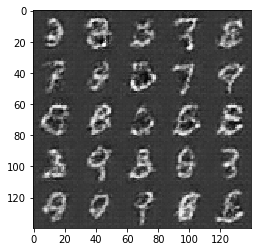

Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 0.7586
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.5229
Epoch 2/2... Discriminator Loss: 0.3920... Generator Loss: 1.8125
Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 1.1318
Epoch 2/2... Discriminator Loss: 0.4573... Generator Loss: 1.8856
Epoch 2/2... Discriminator Loss: 0.3905... Generator Loss: 1.6001
Epoch 2/2... Discriminator Loss: 0.3430... Generator Loss: 1.8359
Epoch 2/2... Discriminator Loss: 0.4612... Generator Loss: 1.4842
Epoch 2/2... Discriminator Loss: 0.3347... Generator Loss: 2.1948
Epoch 2/2... Discriminator Loss: 0.9083... Generator Loss: 0.6386


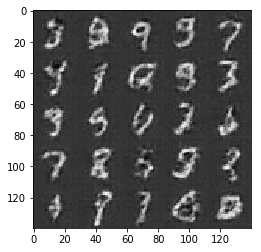

Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.6646
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 0.5107... Generator Loss: 1.5238


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.4341... Generator Loss: 0.0356
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.2899
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 1.7651
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 1.9394
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 2.2679
Epoch 1/1... Discriminator Loss: 0.3027... Generator Loss: 2.3083
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 1.9017


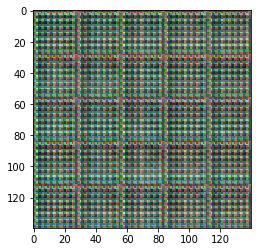

Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.4849... Generator Loss: 1.5065
Epoch 1/1... Discriminator Loss: 0.5677... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.5646
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.7318
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.4635


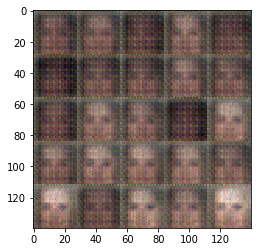

Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 0.6126... Generator Loss: 1.0347
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 3.5451
Epoch 1/1... Discriminator Loss: 0.6866... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.0290
Epoch 1/1... Discriminator Loss: 0.7143... Generator Loss: 1.8399
Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 0.8342... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 2.0691
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 0.8435


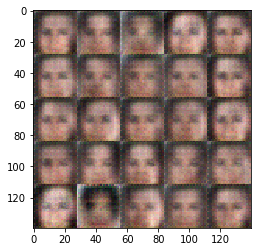

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 0.6121... Generator Loss: 2.8699
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 2.6498
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 4.6024
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 4.2477
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 2.3806
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.9028


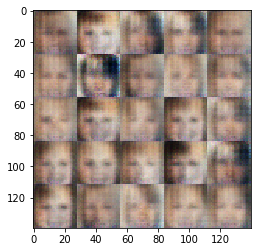

Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 0.4407... Generator Loss: 1.5626
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 2.0426
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 3.2638
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.6007
Epoch 1/1... Discriminator Loss: 0.4589... Generator Loss: 2.7329
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 0.6100... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 2.2175
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 2.2868


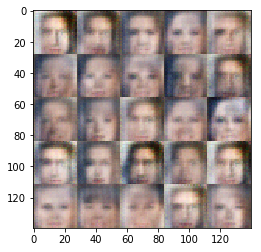

Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 4.0659
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 0.3992... Generator Loss: 3.3413
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 4.1925
Epoch 1/1... Discriminator Loss: 0.7150... Generator Loss: 1.6045
Epoch 1/1... Discriminator Loss: 0.6488... Generator Loss: 1.4697
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 2.2060
Epoch 1/1... Discriminator Loss: 0.3637... Generator Loss: 4.7773
Epoch 1/1... Discriminator Loss: 0.5781... Generator Loss: 1.6884


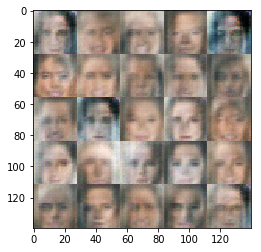

Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.8377
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 3.1789
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 2.0321
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 3.4779
Epoch 1/1... Discriminator Loss: 0.5283... Generator Loss: 1.6108
Epoch 1/1... Discriminator Loss: 0.9497... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 0.3898... Generator Loss: 2.2515


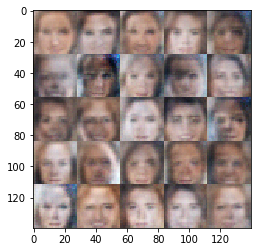

Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 2.2401
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 3.9368
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 1.6705
Epoch 1/1... Discriminator Loss: 0.4876... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 2.7320
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 2.7320
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 0.7753... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 0.5706... Generator Loss: 1.4992


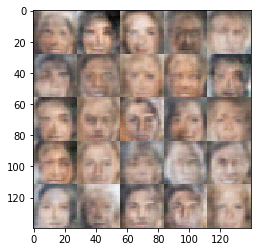

Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 4.7443
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.7642
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 3.8042
Epoch 1/1... Discriminator Loss: 0.7341... Generator Loss: 3.6606
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 2.5105
Epoch 1/1... Discriminator Loss: 0.5226... Generator Loss: 1.8918
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 0.6793... Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 6.0679
Epoch 1/1... Discriminator Loss: 0.4852... Generator Loss: 1.8538


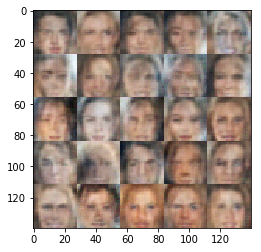

Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 3.9038
Epoch 1/1... Discriminator Loss: 0.4958... Generator Loss: 4.1259
Epoch 1/1... Discriminator Loss: 0.6308... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 0.5851... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 0.4182... Generator Loss: 4.3846
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.4602
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 3.3119
Epoch 1/1... Discriminator Loss: 0.4140... Generator Loss: 5.0541


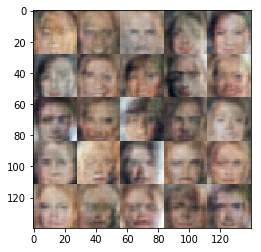

Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 4.2395
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 0.4195... Generator Loss: 4.5019
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.8700
Epoch 1/1... Discriminator Loss: 0.4021... Generator Loss: 3.6084
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 4.2110
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.0426
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 4.0160
Epoch 1/1... Discriminator Loss: 0.6408... Generator Loss: 1.5097


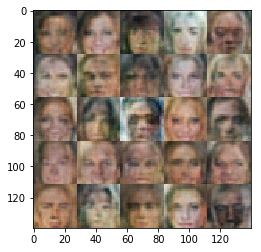

Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.2803
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 0.3854... Generator Loss: 2.9834
Epoch 1/1... Discriminator Loss: 0.4858... Generator Loss: 2.5089
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 2.7221
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.3287
Epoch 1/1... Discriminator Loss: 0.5683... Generator Loss: 4.1529
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 0.5836... Generator Loss: 1.4321


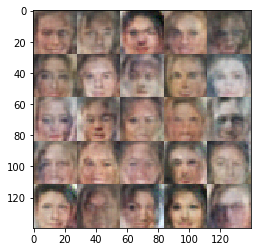

Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.4493
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.6057
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 4.2039
Epoch 1/1... Discriminator Loss: 0.3959... Generator Loss: 6.1556
Epoch 1/1... Discriminator Loss: 0.4423... Generator Loss: 3.5398
Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 2.6501
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 1.4893
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 4.3193
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.1396
Epoch 1/1... Discriminator Loss: 0.4310... Generator Loss: 4.4892


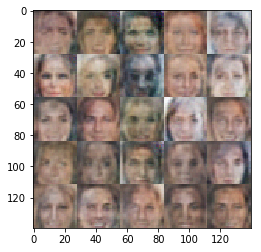

Epoch 1/1... Discriminator Loss: 0.4469... Generator Loss: 2.4065
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 3.3419
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 0.2740... Generator Loss: 2.6087
Epoch 1/1... Discriminator Loss: 0.5313... Generator Loss: 4.8395
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 2.3082
Epoch 1/1... Discriminator Loss: 0.7525... Generator Loss: 4.1801
Epoch 1/1... Discriminator Loss: 0.5863... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 0.6842... Generator Loss: 4.3893


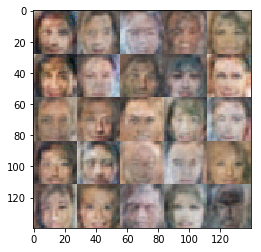

Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 3.0512
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 5.0105
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 3.6169
Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 6.7286
Epoch 1/1... Discriminator Loss: 0.5093... Generator Loss: 1.5185
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 4.7254
Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 2.9412
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 0.3349... Generator Loss: 3.5800


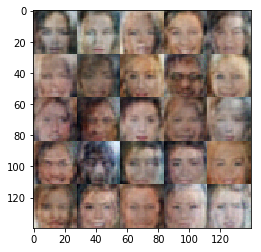

Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 1.2596
Epoch 1/1... Discriminator Loss: 0.2618... Generator Loss: 5.7837
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 1.4800
Epoch 1/1... Discriminator Loss: 0.5280... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 3.9404
Epoch 1/1... Discriminator Loss: 0.2456... Generator Loss: 5.9803
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 3.4528


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.